In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import numpy as np

In [2]:
# coding: utf-8

import tensorflow as tf
import numpy as np


class CNN(object):
    """

    """

    def __init__(self, p_keep_conv=1.0, p_keep_hidden=1.0,
                 batch_size=148, test_size=256, epoch_time=3):
        """
        Initialization
        :param batch_size
        :param test_size
        """
        self.w = self._init_weights([3, 3, 1, 32])  # 第一层卷积核大小为3x3,输入一张图,输出32个feature map
        self.w2 = self._init_weights([3, 3, 32, 64])  # 第二层卷积核大小为3x3,输入32个feature map,输出64个feature map
        self.w3 = self._init_weights([3, 3, 64, 148])  # 第三层卷积核大小为3x3,输入64个feature map,输出148个feature map
        self.w4 = self._init_weights([148 * 6 * 6, 1000])  # FC 148 * 4 * 4 inputs, 625 outputs
        self.w_o = self._init_weights([1000, 10])  # FC 625 inputs, 10 outputs (labels)
        self.batch_size = batch_size
        self.test_size = test_size
        self.sess = tf.Session()  # tensorflow session
        self.p_keep_conv = p_keep_conv
        self.p_keep_hidden = p_keep_hidden
        self.epoch_time = epoch_time

    def _init_weights(self, shape, name=None):
        """
        初始化参数
        :param shape:
        :param name:
        :return:
        """
        return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)


    def _cnn(self, X, p_keep_conv, p_keep_hidden):
        """
        :param X:
        :param p_keep_conv:
        :param p_keep_hidden:
        :return:
        """
        # 第一个卷积层:padding=SAME,保证输出的feature map与输入矩阵的大小相同
        l1a = tf.nn.relu(tf.nn.conv2d(X, self.w,  # l1a shape=(?, 48, 48, 32)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        # max_pooling,窗口大小为2x2
        l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],  # l1 shape=(?, 24, 24, 32)
                            strides=[1, 2, 2, 1], padding='SAME')
        # dropout:每个神经元有p_keep_conv的概率以1/p_keep_conv的比例进行归一化,有(1-p_keep_conv)的概率置为0
        l1 = tf.nn.dropout(l1, p_keep_conv)

        # 第二个卷积层
        l2a = tf.nn.relu(tf.nn.conv2d(l1, self.w2,  # l2a shape=(?, 24, 24, 64)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],  # l2 shape=(?, 12, 12, 64)
                            strides=[1, 2, 2, 1], padding='SAME')
        l2 = tf.nn.dropout(l2, p_keep_conv)

        # 第三个卷积层
        l3a = tf.nn.relu(tf.nn.conv2d(l2, self.w3,  # l3a shape=(?, 12, 12, 148)
                                      strides=[1, 1, 1, 1], padding='SAME'))
        l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],  # l3 shape=(?, 6, 6, 148)
                            strides=[1, 2, 2, 1], padding='SAME')
        # 将所有的feature map合并成一个2048维向量
        l3 = tf.reshape(l3, [-1, self.w4.get_shape().as_list()[0]])  # reshape to (?, 2048)
        l3 = tf.nn.dropout(l3, p_keep_conv)
        # 后面两层为全连接层
        l4 = tf.nn.relu(tf.matmul(l3, self.w4))
        l4 = tf.nn.dropout(l4, p_keep_hidden)
        out = tf.matmul(l4, self.w_o)

        return out


    def fit_new(self, train_x, train_y, test_x, test_y):
        """
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])
        Y = tf.placeholder("float", [None, 10])

        out = self._cnn(X, p_keep_conv, p_keep_hidden)

        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=out, labels=Y))  # 交叉熵目标函数

        train_op = tf.train.AdamOptimizer(0.001, 0.9) \
            .minimize(cost)  # RMSPro算法最小化目标函数

        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        init = tf.global_variables_initializer()

        self.sess.run(init)
        for i in range(self.epoch_time):
            training_batch = zip(range(0, len(train_x), self.batch_size),
                                 range(self.batch_size, len(train_x) + 1, self.batch_size))
            for start, end in training_batch:
                # print(train_x[start:end].shape, train_y[start:end].shape)
                self.sess.run(
                    train_op,
                    feed_dict={X: train_x[start:end],
                               Y: train_y[start:end],
                               p_keep_conv: self.p_keep_conv,
                               p_keep_hidden: self.p_keep_hidden})

            test_indices = np.arange(len(test_x))
            np.random.shuffle(test_indices)
            test_indices = test_indices[0: self.test_size]

            print('epoch %s' % i, np.mean(np.argmax(test_y[test_indices], axis=1) ==
                                          self.sess.run(
                                              predict_op, feed_dict={
                                                  X: test_x[test_indices],
                                                  p_keep_conv: 1.0,
                                                  p_keep_hidden: 1.0})))

    def save(self, model_name):
        """

        :param model_name:
        :return:
        """
        saver = tf.train.Saver()
        saver.save(self.sess, model_name)
        print("save model:{0} Finished".format(model_name))

    def predict(self, img):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])

        out = self._cnn_main(X, p_keep_conv, p_keep_hidden)
        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果

        predict = self.sess.run(
            predict_op, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})

        return predict

    def predict_new(self, img, with_probs=False):
        """

        :param img:
        :return:
        """
        p_keep_conv = tf.placeholder("float")  # 卷积层的dropout概率
        p_keep_hidden = tf.placeholder("float")  # 全连接层的dropout概率
        X = tf.placeholder("float", [None, 48, 48, 1])

        out = self._cnn(X, p_keep_conv, p_keep_hidden)
        predict_op = tf.argmax(out, 1)  # 返回每个样本的预测结果
        if with_probs:
            print(out)
        predict = self.sess.run(
            predict_op, feed_dict={
                X: img.reshape(-1, 48, 48, 1),
                p_keep_conv: 1.0,
                p_keep_hidden: 1.0})

        return predict

    def load_session(self, model_name):
        """

        :param model_name:
        :return:
        """
        # init = tf.global_variables_initializer()
        # self.sess.run(init)
        saver = tf.train.Saver()
        saver.restore(self.sess, model_name)


In [3]:
cnn = CNN()

In [4]:
cnn.load_session('../model/Test_CNN_Model.ckpt')

INFO:tensorflow:Restoring parameters from ../model/Test_CNN_Model.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ../model/Test_CNN_Model.ckpt: Not found: ../model; No such file or directory
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/Users/imperatore/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/imperatore/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2856, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-9fab4496f36c>", line 1, in <module>
    cnn.load_session('../model/Test_CNN_Model.ckpt')
  File "<ipython-input-2-7d98fab7f4f0>", line 186, in load_session
    saver = tf.train.Saver()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on ../model/Test_CNN_Model.ckpt: Not found: ../model; No such file or directory
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [5]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[<tf.Variable 'Variable:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(3, 3, 64, 148) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(5328, 1000) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(1000, 10) dtype=float32_ref>]

In [9]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [10]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

FailedPreconditionError: Attempting to use uninitialized value Variable_4
	 [[Node: Variable_4/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_4)]]

Caused by op 'Variable_4/read', defined at:
  File "/Users/imperatore/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/imperatore/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-b63486be94ec>", line 1, in <module>
    cnn = CNN()
  File "<ipython-input-2-7d98fab7f4f0>", line 23, in __init__
    self.w_o = self._init_weights([1000, 10])  # FC 625 inputs, 10 outputs (labels)
  File "<ipython-input-2-7d98fab7f4f0>", line 38, in _init_weights
    return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 397, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 142, in identity
    return gen_array_ops.identity(input, name=name)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3187, in identity
    "Identity", input=input, name=name)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/imperatore/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable_4
	 [[Node: Variable_4/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Variable_4)]]


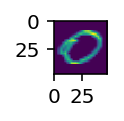

In [11]:
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
        img = (255 - img) / 255.0
        img[img < 0.16] = 0.0

        img = cv2.resize(img, (48, 48))

        sub_img = preprocessing(img)

#             cv2.imwrite(fname, sub_img * 255)

        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        plt.title(cnn.predict_new(sub_img))
    plt.show()

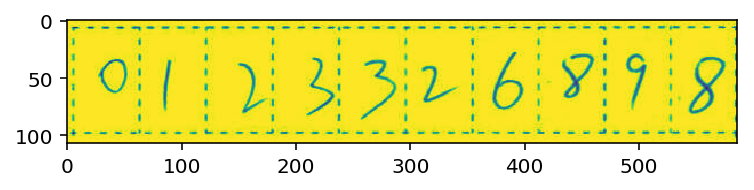

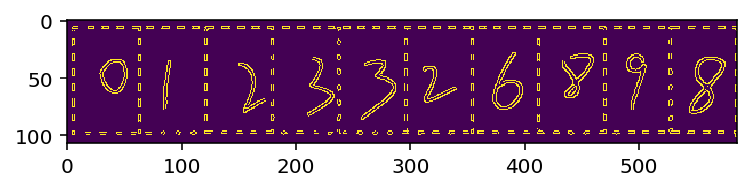

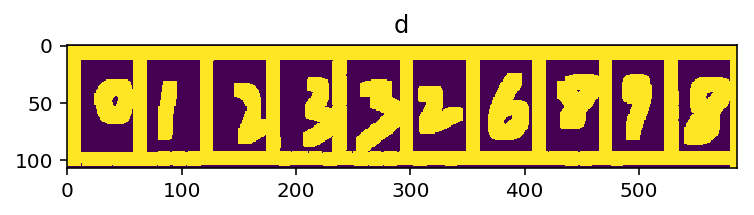

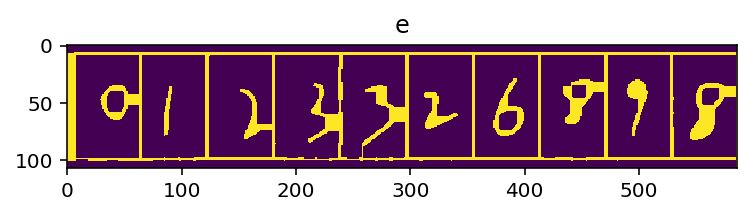

True

In [236]:
img = cv2.imread('testimg/%s/%s.jpg' % (6, '00'), cv2.IMREAD_GRAYSCALE)
# img = (255 - img) / 255.0
# img[img < 0.16] = 0.0
plt.imshow(img)
plt.show()

edges = cv2.Canny(img, 128, 136, apertureSize=3)
plt.imshow(edges)
plt.show()

element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
    
dilation = cv2.dilate(edges, element1, iterations=1)
plt.imshow(dilation)
plt.title('d')
plt.show()

erosion = cv2.erode(dilation, element2, iterations=1)
plt.imshow(erosion)
plt.title('e')
plt.show()

lines = cv2.HoughLines(erosion, 1, np.pi / 180, 80)

# for x1,y1,x2,y2 in lines[0]:
#     cv2.line(img,(x1,y1),(x2,y2),(0,255,0),1)

for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))

    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

cv2.imwrite('testimg/6/houghlines.jpg', img)

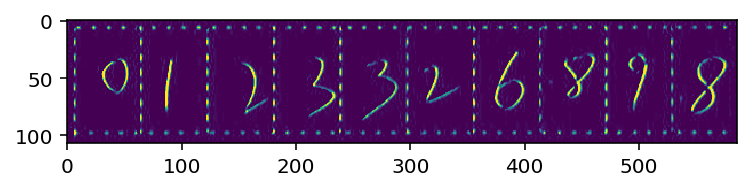

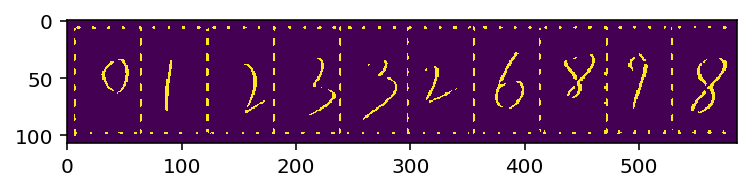

True

In [227]:
img = cv2.imread('testimg/%s/%s.jpg' % (6, '00'), cv2.IMREAD_GRAYSCALE)
sobel = cv2.Sobel(img, cv2.CV_8U, dx=1, dy=0, ksize=3)
plt.imshow(sobel)
plt.show()
ret, binary = cv2.threshold(sobel, 0, 255, cv2.THRESH_OTSU)
plt.imshow(binary)
plt.show()

# dilation = cv2.dilate(binary, (100, 100), iterations=10)
# plt.imshow(dilation)
# plt.show()

# # dilation_hor = cv2.dilate(binary, (3, 500), iterations=10)
# # plt.imshow(dilation_hor)
# # plt.show()

# gau = cv2.GaussianBlur(dilation, (33, 33), 0)
# plt.imshow(gau)

lines = cv2.HoughLinesP(binary, 0.8, np.pi / 180, 100, 100)

for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

# for line in lines:
#     rho, theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * (-b))
#     y1 = int(y0 + 1000 * (a))
#     x2 = int(x0 - 1000 * (-b))
#     y2 = int(y0 - 1000 * (a))

#     cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
cv2.imwrite('testimg/6/houghlines.jpg', img)

In [17]:
cnn.predict_new(sub_img, with_probs=1)[0]

Tensor("MatMul_255:0", shape=(?, 10), dtype=float32)


7

<class 'str'> /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgr/wAARCABaADgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD9/KKarnPNOzigAooJwM03zPapeuwDqKAcjNIWAODU2AWim+YfSinZgNpzntTRjPNK33qrqAFsqBTJJY4hukcKB1JPApWIVSx7V86+NfDvjD9rz4hat4ZsfG+reHvBPhqcWzTaNN5U2qXg5cFiD+7XpVwjHd

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Text(0.5,1,'decoded img')

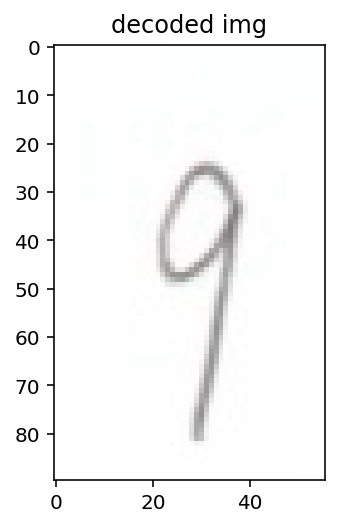

In [103]:
import base64

# img = cv2.imread('testimg/0/2.jpg', cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.title('origin img')
# plt.show()

img_file = open('testimg/0/10.jpg','rb')   # 二进制打开图片文件  
# print(img_file.read())

img_b64encode = base64.b64encode(img_file.read())  # base64编码  
img_file.close()  # 文件关闭  
# print(img_b64encode)

s = img_b64encode.decode()
# s = str(img_b64decode)
print(type(s), s)

img_b64decode = base64.b64decode(s)  # base64解码  

# img_b64decode = base64.b64decode(img_b64encode)  # base64解码  
print(type(img_b64decode))
  
img_array = np.fromstring(img_b64decode,np.uint8) # 转换np序列  
img=cv2.imdecode(img_array,cv2.COLOR_BGR2RGB)  # 转换Opencv格式  

plt.imshow(img)
plt.title('decoded img')

In [109]:
data = []
for i in range(1, 11):
    img = cv2.imread('testimg/0/%s.jpg' % i, cv2.IMREAD_GRAYSCALE)
    img = (255 - img) / 255.0
    img[img < 0.16] = 0.0

    img = cv2.resize(img, (48, 48))

    sub_img = preprocessing(img)
    data.append(sub_img.tolist())
#             cv2.imwrite(fname, sub_img * 255)


In [111]:
np.array(data).shape

(10, 48, 48)

In [6]:
from keras.callbacks import *
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [7]:
model = load_model('resnet3.h5')

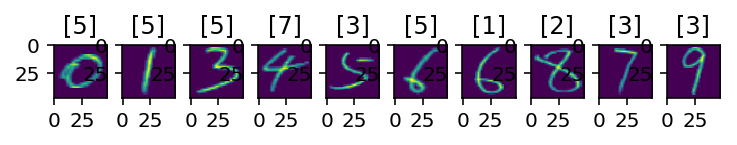

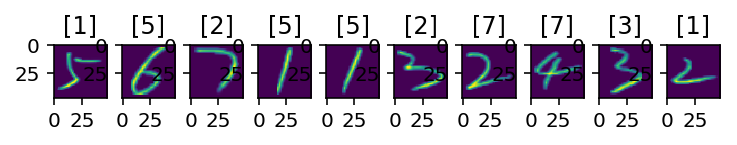

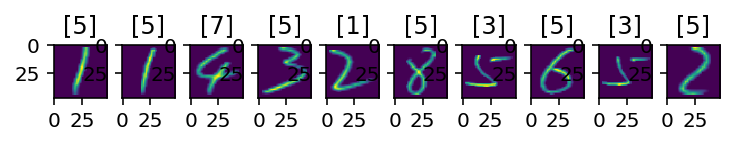

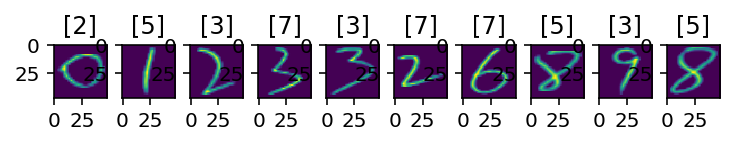

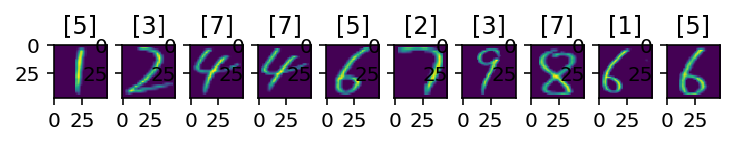

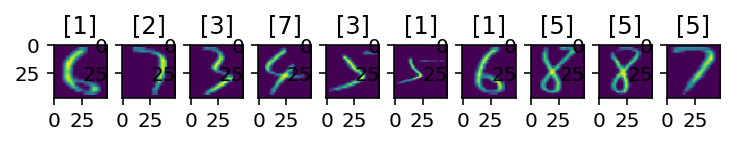

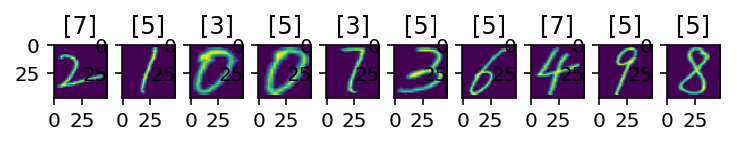

In [30]:
for j in range(0, 7):
    
    for i in range(1, 11):
        img = cv2.imread('testimg/%s/%s.jpg' % (j, i), cv2.IMREAD_GRAYSCALE)
        img = (255 - img) / 255.0
        img[img < 0.12] = 0.0

        img = cv2.resize(img, (48, 48))

        sub_img = preprocessing(img)

#             cv2.imwrite(fname, sub_img * 255)

        plt.subplot(7, 10, i + j * 10)
        plt.imshow(sub_img)
        sub_img = np.expand_dims(sub_img, axis=0)
        sub_img = np.expand_dims(sub_img, axis=-1)
#         print(sub_img[0].shape)
        plt.title(np.argmax(model.predict(sub_img), axis=-1))
    plt.show()

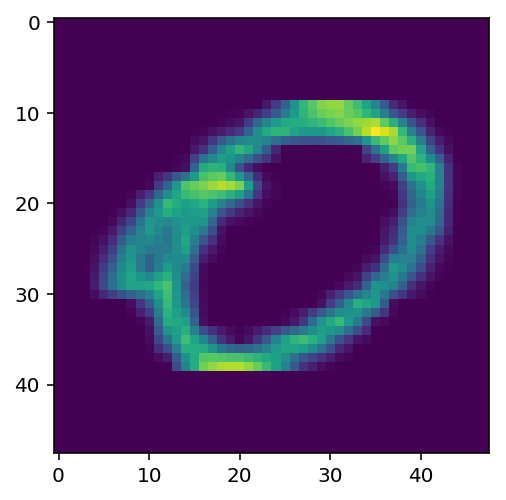

In [25]:
img = cv2.imread('testimg/%s/%s.jpg' % (0, 1), cv2.IMREAD_GRAYSCALE)
img = (255 - img) / 255.0
img[img < 0.12] = 0.0
img = cv2.resize(img, (48, 48))
sub_img = preprocessing(img)
plt.imshow(sub_img)


In [26]:
sub_img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
sub_img = np.expand_dims(sub_img, axis=0)
sub_img = np.expand_dims(sub_img, axis=-1)
sub_img[0].shape

(48, 48, 1)

In [34]:
np.argmax(model.predict(sub_img))

5